## Informações sobre o aluno:

Nomes: Hugo & Thiago (dupla sertaneja)

Matrícula: 202204590 &

## Questão 1

Você foi convidado para participar de um projeto de uma empresa BIA Technologies, uma empresa voltada para o comércio de jogos para video-games e computadores. Esse projeto conta com uma equipe de sistemas de recomendação, na qual você foi convidado a participar. Dessa forma, você irá auxiliar o desenvolvimento de um sistema de recomendação para essa empresa.

Considere o dataset fornecido pela empresa e faça uma análise básica desse dataset. Em seguida, utilize seus conhecimentos para desenvolver e avaliar três diferentes sistemas de recomendação da seguinte forma:

a) Desenvolva um sistema de recomendação utilizando filtragem colaborativa (sem realizar a redução da dimensionalidade dos dados);

b) Desenvolva um sistema de recomendação baseado em conteúdo (sem realizar a redução da dimensionalidade dos dados);

c) Desenvolva um sistema de recomendação utilizando a redução da dimensionalidade dos dados.

Forneça as métricas de avaliações para cada um dos sistemas. Conclua suas observações de forma a convencer o gestor do projeto sobre qual foi o melhor sistema de recomendação obtido até o momento.

**Entrega da resolução da prova: dia 03/12/2024 até as 23:59, via SIGAA.**

**Obs.:** A outra equipe de sistemas de recomendação da empresa BIA Technologies apresentou uma solução atingindo as métricas abaixo. Seu sistema deverá fornecer métricas melhores que as obtidas pela outra equipe (baseline):

'ndcg@5' = 0.0016818836315317604

'ndcg@10' = 0.003073280417540927

'precision@5' = 0.00016758439071103669

'precision@10' = 8.379219535551834e-05

In [7]:
ndcgA5_prova = 0.0016818836315317604
ndcgA10_prova = 0.003073280417540927
precisionA5_prova = 0.00016758439071103669
precisionA10_prova = 8.379219535551834e-05

## Conjunto de Dados

In [8]:
import os
import json
import gzip
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
import time

In [9]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz

--2024-12-04 11:41:58--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/Video_Games_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154050105 (147M) [application/x-gzip]
Saving to: ‘Video_Games_5.json.gz’

Video_Games_5.json. 100%[===================>] 146.91M  13.0MB/s    in 8.0s    

2024-12-04 11:42:06 (18.3 MB/s) - ‘Video_Games_5.json.gz’ saved [154050105/154050105]



In [10]:
!wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Video_Games.json.gz

--2024-12-04 11:42:07--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/metaFiles2/meta_Video_Games.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53175983 (51M) [application/x-gzip]
Saving to: ‘meta_Video_Games.json.gz’

meta_Video_Games.js 100%[===================>]  50.71M  33.7MB/s    in 1.5s    

2024-12-04 11:42:08 (33.7 MB/s) - ‘meta_Video_Games.json.gz’ saved [53175983/53175983]



In [11]:
def load_file(file_name):
    data = []
    with gzip.open(file_name) as f:
        for l in f:
            data.append(json.loads(l.strip()))

    print(file_name, len(data))
    df = pd.DataFrame.from_dict(data)
    return df

reviews_df = load_file("Video_Games_5.json.gz")
metadata_df = load_file("meta_Video_Games.json.gz")

Video_Games_5.json.gz 497577
meta_Video_Games.json.gz 84819


### Descrição das colunas reviews_df
- reviewerID - ID do avaliador, por exemplo, A2SUAM1J3GNN3B
- asin - ID do produto, por exemplo, 0000013714
- reviewerName - nome do avaliador
- vote - votos úteis da avaliação
- style - um dicionário dos metadados do produto, por exemplo, "Formato" é "Capa Dura"
- reviewText - texto da avaliação
- overall - classificação do produto
- summary - resumo da avaliação
- unixReviewTime - tempo da avaliação (tempo Unix)
- reviewTime - tempo da avaliação (formato original)
- image - imagens que os usuários postam após receberem o produto

In [12]:
reviews_df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4.0,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3.0,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2.0,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5.0,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


### Descrição das colunas metadata_df

- asin - ID do produto, por exemplo, 0000031852
- title - nome do produto
- feature - características do produto em formato de lista de itens
- description - descrição do produto
- price - preço em dólares americanos (no momento da coleta de dados)
- imageURL - URL da imagem do produto
- imageURLHighRes - URL da imagem do produto em alta resolução
- related - produtos relacionados (também comprados, também visualizados comprados juntos, comprar após visualizar)
- salesRank - informações do ranking de vendas
- brand - nome da marca
- categories - lista de categorias às quais o produto pertence
- tech1 - primeira tabela de detalhes técnicos do produto
- tech2 - segunda tabela de detalhes técnicos do produto
- similar - tabela de produtos similares

In [13]:
metadata_df.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,details
0,"[Video Games, PC, Games]",,[],,Reversi Sensory Challenger,[],,Fidelity Electronics,[],"[>#2,623,937 in Toys &amp; Games (See Top 100 ...",[],Toys &amp; Games,,,,0042000742,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
1,"[Video Games, Xbox 360, Games, </span></span><...",,[Brand new sealed!],,Medal of Honor: Warfighter - Includes Battlefi...,[B00PADROYW],,by\n \n EA Games,[],"[>#67,231 in Video Games (See Top 100 in Video...","[B0050SY5BM, B072NQJCW5, B000TI836G, B002SRSQ7...",Video Games,,,"\n\t\t\t\t\t\t\t\t\t\t\t\t<span class=""vertica...",0078764343,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
2,"[Video Games, Retro Gaming & Microconsoles, Su...",,[],,street fighter 2 II turbo super nintendo snes ...,[],,Nintendo,[],"[>#134,433 in Video Games (See Top 100 in Vide...",[],Video Games,,,$0.72,0276425316,[],[],NaN
3,"[Video Games, Xbox 360, Accessories, Controlle...",,[MAS's Pro Xbox 360 Stick (Perfect 360 Stick) ...,,Xbox 360 MAS STICK,[],,by\n \n MAS SYSTEMS,[Original PCB used from Xbox 360 Control Pad (...,"[>#105,263 in Video Games (See Top 100 in Vide...",[],Video Games,,,,0324411812,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN
4,"[Video Games, PC, Games, </span></span></span>...",,"[Phonics Alive! 3, The Speller teaches student...",,Phonics Alive! 3: The Speller,[],,by\n \n Advanced Software Pty. Ltd.,"[Grades 2-12, Spelling Program, Teaches Spelli...","[>#92,397 in Video Games (See Top 100 in Video...",[B000BCZ7U0],Video Games,,,,0439335310,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,NaN


Note que o dataset é muito grande e certas manipulações podem não caber na memória RAM. Além disso, alguns desses dados podem ser de baixa qualidade. Esses dados podem ser filtrados e você pode considerar apenas os dados de maior qualidade. Alguns filtros básicos:

In [14]:
reviews_df_filtrado = reviews_df.copy()

# Conversão do unixReviewTime para um formato de data legível
reviews_df_filtrado['reviewDate'] = pd.to_datetime(reviews_df_filtrado['unixReviewTime'], unit='s')

# Removendo duplicatas e valores nulos
reviews_df_filtrado.dropna(subset=['reviewerID', 'asin', 'overall'], inplace=True)
reviews_df_filtrado.drop(['unixReviewTime', 'reviewTime'], axis=1, inplace=True)

In [15]:
# Removendo duplicatas e valores nulos
metadata_df.drop_duplicates(subset=['asin'], inplace=True)
metadata_df.dropna(subset=['asin', 'title'], inplace=True)

In [16]:
# Identificando os IDs de produtos únicos em metadata_df
produtos_validos = set(metadata_df['asin'])

# Filtrando reviews_df para manter apenas as linhas com produtos que estão em metadata_df
reviews_df_filtrado = reviews_df_filtrado[reviews_df_filtrado['asin'].isin(produtos_validos)]

# Verificando o resultado
print(f"Número original de linhas em reviews_df: {len(reviews_df)}")
print(f"Número de linhas após a filtragem: {len(reviews_df_filtrado)}")
reviews_df = reviews_df_filtrado

Número original de linhas em reviews_df: 497577
Número de linhas após a filtragem: 496315


In [17]:
# Identificando os IDs de produtos únicos em reviews_df
produtos_validos = set(reviews_df['asin'])

# Filtrando metadata_df para manter apenas as linhas com produtos que estão em reviews_df
metadata_df_filtrado = metadata_df[metadata_df['asin'].isin(produtos_validos)]

# Verificando o resultado
print(f"Número original de linhas em metadata_df: {len(metadata_df)}")
print(f"Número de linhas após a filtragem: {len(metadata_df_filtrado)}")
metadata_df = metadata_df_filtrado

Número original de linhas em metadata_df: 71911
Número de linhas após a filtragem: 17389


## Resolução

### **Análise e preparação dos dados (0,5 pontos)**

> Realize análise prévia dos dados. Prepare-os aplicando filtros e selecionando features relevantes.

> Insira comentários no decorrer do código

>> `Conferir` se tem algum nulo ainda

In [18]:
print(reviews_df.info())
print("--------")
print(metadata_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 496315 entries, 0 to 497576
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   overall       496315 non-null  float64       
 1   verified      496315 non-null  bool          
 2   reviewerID    496315 non-null  object        
 3   asin          496315 non-null  object        
 4   reviewerName  496239 non-null  object        
 5   reviewText    496157 non-null  object        
 6   summary       496206 non-null  object        
 7   vote          107388 non-null  object        
 8   style         288079 non-null  object        
 9   image         3631 non-null    object        
 10  reviewDate    496315 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(1), object(8)
memory usage: 42.1+ MB
None
--------
<class 'pandas.core.frame.DataFrame'>
Index: 17389 entries, 38 to 84810
Data columns (total 19 columns):
 #   Column           Non-Null 

>> Escolhemos algumas colunas dos datasets que acreditamos serem importantes para o modelo de recomendação. (fizemos alguns testes utilizando umas, retirnado outras, enfim, aqui foi mais pra tirar colunas que nao faziam sentido de trabalhar como "image". São elas:

* `overall`: avaliação (nota) dada pelo usuário. Essencial para entender a preferência do usuário.
* `verified`: Indica se a compra foi verificada
* `reviewerID`: identificador único do usuário. Necessário para mapear interações entre usuários.
* `style`: indica caracterisitcas unicas daquela tupla.
* `asin`: identificador único do produto, é a chave entre reviews_df e metadata_df.
* `reviewText`: texto completo da avaliação, vou explorar mais depois.
* `summary`: resumo da avaliação, vou explorar mais depois.
* `vote`: qtde de votos que uma avaliação recebeu.
* `reviewDate`: informações temporais. Serveria apenas para saber quais foram os reviwes mais recentes do usuário.
--------------------------------------------------------------
* `category`: categorias do produto. Ideal para criar clusters ou segmentar produtos.
* `brand`: importantes para usuários com preferências, eu acho.
* `main_cat`: Categoria principal do produto.
* `price`: Preço do produto, ideal caso eu queria utilizar preço para recomendar.
* `asin`: ID único do produto, chave para associar metadata_df com reviews_df.
* `description`: contem descrição do item

In [19]:
# reviews_df['style'] contém dicionários ou strings no formato JSON, logo vamos retirar pra tentar usar essa informação

# extrair o conteúdo do dicionário 'style', Suco do GPT
def extrair_style(style):
    if isinstance(style, dict):
        return ', '.join([f"{key}: {value}" for key, value in style.items()])
    elif isinstance(style, str):
        try:
            import json
            style_dict = json.loads(style)
            return ', '.join([f"{key}: {value}" for key, value in style_dict.items()])
        except json.JSONDecodeError:
            return style
    return None

reviews_df['style'] = reviews_df['style'].apply(extrair_style)

In [20]:
# valores únicos
valores_unicos = reviews_df['style'].unique()
print(valores_unicos)

[None 'Format::  Hardcover' 'Format::  DVD-ROM' ...
 'Color::  01 - Xbox 360 PS4 Wii U - Black/White'
 'Edition::  In Too Deep, Platform::  PS4 Digital Code'
 'Style::  Definitive Edition']


In [21]:
# remover texto antes de "::"
reviews_df['style'] = reviews_df['style'].str.split("::").str[-1].str.strip()

In [22]:
# mantendo as colunas necessárias
reviews_df = reviews_df[['overall', 'verified', 'reviewerID', 'asin', 'reviewText', 'summary', 'vote', 'reviewDate', 'style']]
metadata_df = metadata_df[['category', 'brand', 'main_cat', 'price', 'asin','description']]

In [23]:
# convertendo a coluna 'vote' para numérico
reviews_df['vote'] = pd.to_numeric(reviews_df['vote'], errors='coerce')

<ipython-input-23-2e33eebf7122>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['vote'] = pd.to_numeric(reviews_df['vote'], errors='coerce')


In [24]:
# convertendo a coluna 'price' para numérico
metadata_df['price'] = pd.to_numeric(metadata_df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')

<ipython-input-24-9d69d9e9b5cc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_df['price'] = pd.to_numeric(metadata_df['price'].str.replace('$', '').str.replace(',', ''), errors='coerce')


>> Notamos que existes ` mais que jogos` nesse dataset, entao vmaos remover alguns que nao fazem snetido que sao acessorios.

In [25]:
# palavras que quero retirar
keywords_to_remove = ["Accessories", "Controlle", "Controller"]

# Filtrar o DataFrame
metadata_df = metadata_df[~metadata_df['category'].apply(
    lambda x: any(keyword in str(x) for keyword in keywords_to_remove)
)]

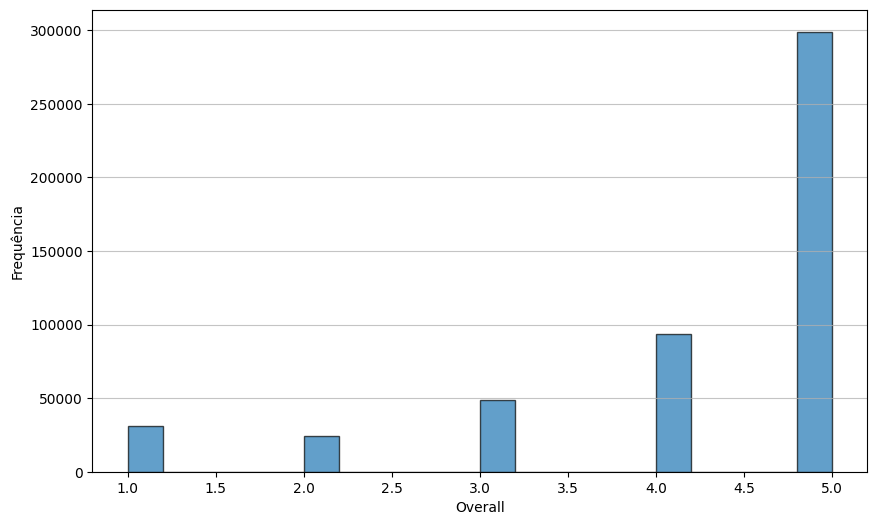

In [26]:
# histograma das notas
plt.figure(figsize=(10, 6))
plt.hist(reviews_df['overall'].dropna(), bins=20, edgecolor='k', alpha=0.7)
plt.xlabel('Overall')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

### **a) (2,0 pontos) Modelo de recomendação com filtragem colaborativa**

> Implemente um sistema de recomendação utilizando filtragem colaborativa

> Insira comentários no decorrer do código

A filtragem colaborativa utiliza os comportamentos ou preferências dos usuários para sugerir itens. Baseia-se na premissa de que usuários com gostos semelhantes provavelmente gostarão dos mesmos produtos. Abordagens chamada de **user-based**, que recomenda itens com base nas preferências de usuários com comportamentos similares.

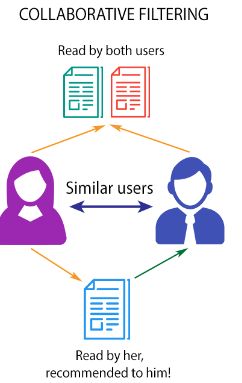

Primeiramente criamos um Modelo de recomendação com filtragem colaborativa sem redução de dimensionalidade e o testamos. Porém, era preciso realizar o "treinamento" desse modelo e fazer o teste tambem. Para isso, separaramos o dataset em treino e teste, porem de uma forma diferente.

Pegamos o dataset total, fazemos um groupby por id de usuário. Desse conjunto, dividimos em treino e teste (80/20). Exemplo se um usuário apareceu 10 vezes, 8 tuplas vao pra treino e 2 vao pra teste.

Outro ponto é que no teste tem que conter as tuplas mais receites, ordenadas pela data. Ou seja, os dados de treino serão as ultimas compras desse usuário. O treino entao será os dados que modelo possui para recomendar. Teste é o que ele nunca viu.

Para a avaliação vamos utilizar 4 métricas: 'ndcg@5', 'ndcg@10', 'precision@5', 'precision@10'. Esse 5 e 10 são os n primeiras recomendações feitas. Pelo que entendemos, para a precisão, dada uma lista de recomendações pelo conjunto de treino, há nela algum jogo que está no conjunto de teste? Se sim, a precisão é retirada desse acerto.

Para outra métrica ndcg vamos considerar o indice dos jogos de teste dentro da lista de recomendações feitas, ou seja, dado que acertei o quão bom esse acerto está posicionado na minha lista de recomendações.

Por fim, tivemos outro problema que é o uso da memória RAM. Por estar usando colab estouramos a RAM toda hora, não é atoa que estou usando uma versao fracionada do dataset original. Adotamos algumas formas de contornar isso, em parte, como matriz esparças.

In [27]:
# ordenar o dataset por `reviewDate`
reviews_df = reviews_df.sample(frac=0.30, random_state=42)
reviews_df = reviews_df.sort_values(['reviewerID', 'reviewDate'])

# treino e teste (80/20) por cada usuario
def split_train_test(data, test_ratio=0.2):
    train_data, test_data = [], []
    for user_id, group in data.groupby('reviewerID'):
        n_test = int(len(group) * test_ratio)
        train_data.append(group.iloc[:-n_test])
        test_data.append(group.iloc[-n_test:])
    return pd.concat(train_data), pd.concat(test_data)

train_df, test_df = split_train_test(reviews_df)

>> A ideia aqui é usar outras informacoes para compor a matriz de principal e ponderar essas informacoes com pesos, afinal uma reocmendacao bem feita leva em consideracao mais de um fator para isso, ou seja, nao usaremos apenas as notas, mas tbm o quanto esse filme eh avaliado e se eh verificado ou nao

In [28]:
# funcao para matriz combinada
def build_combined_matrix(data, weights):
    matrix_overall = data.pivot_table(index='reviewerID', columns='asin', values='overall', fill_value=0)
    matrix_verified = data.pivot_table(index='reviewerID', columns='asin', values='verified', fill_value=0)
    matrix_votes = data.pivot_table(index='reviewerID', columns='asin', values='vote', fill_value=0)

    # pesos para a combinação das matrizes
    combined_matrix = (
        matrix_overall * weights.get('overall', 0.7) +
        matrix_verified * weights.get('verified', 0.2) +
        matrix_votes * weights.get('vote', 0.1)
    )

    combined_matrix.fillna(0, inplace=True)

    return csr_matrix(combined_matrix.values), combined_matrix.index, combined_matrix.columns

In [29]:
weights = {'overall': 0.7, 'verified': 0.2, 'vote': 0.1}
train_matrix, user_ids, item_ids = build_combined_matrix(train_df, weights)

# similaridade de cosseno entre usuários usando
user_similarity = cosine_similarity(train_matrix, dense_output=False)

In [30]:
# função da recomendação
def recomendar_produtos(user_id, train_matrix, user_similarity, user_ids, item_ids, n_recommendations=10):
    user_index = user_ids.get_loc(user_id)
    similar_users = user_similarity[user_index].toarray().flatten()
    scores = train_matrix.T.dot(similar_users)

    # filtrando itens já avaliados pelo usuario antes
    user_items = train_matrix[user_index].toarray().flatten()
    scores[user_items > 0] = -np.inf

    recommended_indices = np.argsort(scores)[::-1][:n_recommendations]
    return [item_ids[i] for i in recommended_indices]

In [31]:
# métricas de avaliação
def ndcg(recommended_items, relevant_items, k=5):
    dcg = sum((1 / np.log2(i + 2)) for i, item in enumerate(recommended_items[:k]) if item in relevant_items)
    idcg = sum((1 / np.log2(i + 2)) for i in range(min(len(relevant_items), k)))
    return dcg / idcg if idcg > 0 else 0

def precision(recommended_items, relevant_items, k=5):
    return sum(1 for item in recommended_items[:k] if item in relevant_items) / k

# avaliar o modelo
def avaliar_modelo(test_df, train_matrix, user_similarity, user_ids, item_ids, k_values=[5, 10]):
    resultados = {'ndcg@5': [], 'ndcg@10': [], 'precision@5': [], 'precision@10': []}
    for user_id in test_df['reviewerID'].unique():
        if user_id not in user_ids:
            continue

        relevant_items = test_df[test_df['reviewerID'] == user_id]['asin'].tolist()
        recommended_items = recomendar_produtos(user_id, train_matrix, user_similarity, user_ids, item_ids, max(k_values))

        for k in k_values:
            resultados[f'ndcg@{k}'].append(ndcg(recommended_items, relevant_items, k))
            resultados[f'precision@{k}'].append(precision(recommended_items, relevant_items, k))

    return {m: np.mean(valores) for m, valores in resultados.items()}

In [133]:
start_time = time.time()

# avaliar o modelo
resultados = avaliar_modelo(test_df, train_matrix, user_similarity, user_ids, item_ids)

mdl_1_tempo = time.time() - start_time  # tempo total de execução

# salvar as métricas com a tag "mdl_1_"
resultados_tagged = {f"mdl_1_{metric}": value for metric, value in resultados.items()}

print("Resultados:")
for metric, value in resultados.items():
    print(f"{metric}: {value:.20f}")
print(f"Tempo de execução (mdl_1_tempo): {mdl_1_tempo:.4f} segundos")

Resultados:
ndcg@5: 0.00464937475792793695
ndcg@10: 0.00559391863222122570
precision@5: 0.00168619605601600460
precision@10: 0.00127179194055444421
Tempo de execução (mdl_1_tempo): 290.2078 segundos


In [135]:
# comparando os resultados com os valores de prova
comparacoes = {
    "ndcg@5": resultados["ndcg@5"] > ndcgA5_prova,
    "ndcg@10": resultados["ndcg@10"] > ndcgA10_prova,
    "precision@5": resultados["precision@5"] > precisionA5_prova,
    "precision@10": resultados["precision@10"] > precisionA10_prova
}

for metrica, resultado in comparacoes.items():
    print(f"- {metrica} > {metrica}_prova -> {resultado}")

- ndcg@5 > ndcg@5_prova -> True
- ndcg@10 > ndcg@10_prova -> True
- precision@5 > precision@5_prova -> True
- precision@10 > precision@10_prova -> True


### **b) (2,0 pontos) Modelo de recomendação baseado em conteúdo**

> Implemente um sistema de recomendação baseado em conteúdo

> Insira comentários no decorrer do código

Sistema de recomendação baseado em conteúdo utiliza as características dos itens para fazer sugestões personalizadas aos usuários. O modelo analisa as propriedades ou descrições dos itens que o usuário avaliou positivamente e identifica outros itens com características semelhantes.

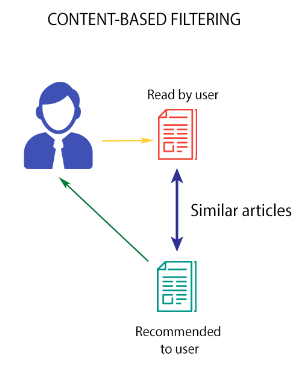

>>  Pro estar utilizando informacoes de texto contidas em metadata_df['description'] e metadata_df['category'] escolhemos utilizar uma abordagem de `NLP chamada TF-IDF (Term Frequency-Inverse Document Frequency)` que ajuda a destacar as informações mais relevantes nos dados textuais associados aos itens. Essa técnica atribui maior peso para as palavras que aparecem com frequência em um item, mas que são menos comuns em todo o conjunto de dados, reduzindo o impacto de palavras genéricas ou muito frequentes.

>> Esses dados textuais com mais importância são então transformados em representações numéricas vetoriais, o que é essencial para cálculos como similaridade de cosseno.

In [32]:
# transformar o dataset `metadata_df` para incluir as features combinadas

# category seja uma string única ao invés de uma lista.
metadata_df['category'] = metadata_df['category'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

#brand incluem quebras de linha (\n)
metadata_df['brand'] = metadata_df['brand'].str.replace(r'\s+', ' ', regex=True).str.strip()

#ubstitui NaN por um valor padrão, como Unknown ou 0:
#metadata_df['price'] = metadata_df['price'].fillna('Unknown')

# utilizar a coluna descrição tbm
metadata_df['description'] = metadata_df['description'].fillna('Unknown')

# vou colocar essa combinação tudo em uma nova coluna de texto
# category, main_cat, brand e price para representar o conteúdo do item tudo aglutinado
metadata_df['combined_features'] = (
    metadata_df['category'].astype(str) + " " +
    metadata_df['main_cat'].astype(str) + " " +
    metadata_df['brand'].astype(str) + " " +
    metadata_df['description'].astype(str)
)

In [33]:
# fazer a representação vetorial dos itens usando TF-IDF
# vamos ignorar palavras muito comuns ou entãao pouco frequentes
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
item_profiles = tfidf_vectorizer.fit_transform(metadata_df['combined_features'])

In [34]:
# função da recomendaçao de itens com base em conteúdo
def recomendar_baseado_em_conteudo(item_id, metadata_df, item_profiles, n_recommendations=10):
    # verificar se tem o id no DataFrame
    if item_id not in metadata_df['asin'].values:
        return []

    # índice do item no DataFrame
    item_index = metadata_df[metadata_df['asin'] == item_id].index[0]

    # calculo de similaridade de cosseno entre o item alvo e todos os outros
    #similarity_scores = cosine_similarity(item_profiles[item_index], item_profiles).flatten()
    similarity_scores = cosine_similarity(
        item_profiles[item_index],
        item_profiles,
        dense_output=False
    ).toarray().flatten()

    # ordena os itens
    similar_items = similarity_scores.argsort()[::-1]

    # pegando os itens mais similares
    recommended_item_indices = [i for i in similar_items if i != item_index][:n_recommendations]
    recommended_items = metadata_df.iloc[recommended_item_indices]

    return recommended_items['asin'].tolist()

In [35]:
# avaliar o modelo
def avaliar_modelo_conteudo(test_df, train_df, metadata_df, item_profiles, k_values=[5, 10]):
    resultados = {'ndcg@5': [], 'ndcg@10': [], 'precision@5': [], 'precision@10': []}
    train_items = train_df['asin'].unique()

    for user_id in test_df['reviewerID'].unique():
        user_test_items = test_df[test_df['reviewerID'] == user_id]['asin'].tolist()
        user_train_items = train_df[train_df['reviewerID'] == user_id]['asin'].tolist()

        if not user_train_items or not user_test_items:
            continue

        # aqui sao ecomendacoes baseadas nos itens do dataset de treino
        recommended_items = []
        for train_item in user_train_items:
            if train_item in metadata_df['asin'].values:
                recommended_items.extend(
                    recomendar_baseado_em_conteudo(train_item, metadata_df, item_profiles, max(k_values))
                )

        # remove duplicatas, tada dando erro de mais
        recommended_items = list(dict.fromkeys(recommended_items))

        for k in k_values:
            top_k_items = recommended_items[:k]
            resultados[f'ndcg@{k}'].append(ndcg(top_k_items, user_test_items, k))
            resultados[f'precision@{k}'].append(precision(top_k_items, user_test_items, k))

    return {m: np.mean(valores) for m, valores in resultados.items()}

In [25]:
#tive de resetar o index pq sempre tava causando erro de index nao achado
metadata_df = metadata_df.reset_index(drop=True)

In [143]:
start_time = time.time()

# avaliação
resultados_conteudo = avaliar_modelo_conteudo(test_df, train_df, metadata_df, item_profiles)
mdl_2_tempo = time.time() - start_time  # tempo total de execução

# renomear as métricas
resultados_conteudo_tagged = {f"mdl_2_{metric}": value for metric, value in resultados_conteudo.items()}


print("Resultados do Modelo Baseado em Conteúdo:")
for metric, value in resultados_conteudo_tagged.items():
    print(f"{metric}: {value:.20f}")
print(f"Tempo de execução (mdl_2_tempo): {mdl_2_tempo:.4f} segundos")

Resultados do Modelo Baseado em Conteúdo:
ndcg@5: 0.00338071638975232652
ndcg@10: 0.00459012988925157350
precision@5: 0.00120034295513003720
precision@10: 0.00105744498428122342
Tempo de execução (mdl_conteudo_tempo): 5277.5195 segundos


In [144]:
# comparando os resultados com os valores de prova
comparacoes = {
    "ndcg@5": resultados_conteudo["ndcg@5"] > ndcgA5_prova,
    "ndcg@10": resultados_conteudo["ndcg@10"] > ndcgA10_prova,
    "precision@5": resultados_conteudo["precision@5"] > precisionA5_prova,
    "precision@10": resultados_conteudo["precision@10"] > precisionA10_prova
}

print("Comparação com os valores de prova:")
for metrica, resultado in comparacoes.items():
    print(f"- {metrica} > {metrica}_prova -> {resultado}")

Comparação com os valores de prova:
- ndcg@5 > ndcg@5_prova -> True
- ndcg@10 > ndcg@10_prova -> True
- precision@5 > precision@5_prova -> True
- precision@10 > precision@10_prova -> True


### **c) (2,0 pontos) Modelo de recomendação aplicando a redução da dimensionalidade**

Vamos usar o PCA (Análise de Componentes Principais) para reduzir a dimensionalidade do modelo de recomendação baseado no modelo de filtragem colaborativa, simplesmente porque ele eh mais rapido. A reudcao da dimensionalidade pode ajudar a melhorar o desempenho computacional, afinal as matrizes serao melhores, permitindo uma análise do impacto na qualidade das recomendações, que é a ideia da comparacao aao final dessa atividade.

#### **Modelo de recomendação com filtragem colaborativa**` com PCA`

>> aporveitei as mesmas funcoes do outro modelo, apenas reduzi a dimensionalidade da matriz

In [145]:
# PCA para redução da dimensionalidade
def reduzir_dimensionalidade(matrix, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_matrix = pca.fit_transform(matrix.toarray())
    return csr_matrix(reduced_matrix), pca

In [146]:
# matriz combinada e aplicar o PCA, mesmo pesos da outra
#weights = {'overall': 0.7, 'verified': 0.2, 'vote': 0.1}
#train_matrix, user_ids, item_ids = build_combined_matrix(train_df, weights)

train_matrix_reduced, pca_model = reduzir_dimensionalidade(train_matrix, n_components=50)

In [147]:
# calcuilar a similaridade de cosseno entre usuários na matriz reduzida
user_similarity_reduced = cosine_similarity(train_matrix_reduced, dense_output=False)

In [148]:
start_time = time.time()

# avaliação do modelo
resultados_pca = avaliar_modelo(test_df, train_matrix_reduced, user_similarity_reduced, user_ids, item_ids)
mdl_1_pca_tempo = time.time() - start_time

# Renomear as métricas com a tag "mdl_2_pca_"
resultados_pca_filtragem = {f"mdl_1_pca_{metric}": value for metric, value in resultados_pca.items()}

#resultados
print("Resultados com PCA:")
for metric, value in resultados_pca_filtragem.items():
    print(f"{metric}: {value:.20f}")

print(f"Tempo de execução (mdl_1_pca_tempo): {mdl_1_pca_tempo:.4f} segundos")

Resultados com PCA:
mdl_2_pca_ndcg@5: 0.00030421743873041047
mdl_2_pca_ndcg@10: 0.00059351982945852414
mdl_2_pca_precision@5: 0.00017147756501857675
mdl_2_pca_precision@10: 0.00018576736210345812
Tempo de execução (mdl_2_pca_tempo): 309.3272 segundos


In [149]:
# comparando os resultados com os valores de prova
comparacoes_pca = {
    "ndcg@5": resultados_pca["ndcg@5"] > ndcgA5_prova,
    "ndcg@10": resultados_pca["ndcg@10"] > ndcgA10_prova,
    "precision@5": resultados_pca["precision@5"] > precisionA5_prova,
    "precision@10": resultados_pca["precision@10"] > precisionA10_prova
}

for metrica, resultado in comparacoes_pca.items():
    print(f"- {metrica} > {metrica}_prova -> {resultado}")

- ndcg@5 > ndcg@5_prova -> False
- ndcg@10 > ndcg@10_prova -> False
- precision@5 > precision@5_prova -> True
- precision@10 > precision@10_prova -> True


#### **Modelo de recomendação baseado em conteúdo** `com PCA`

In [36]:
# aplicar PCA para reduzir dimensionalidade no modelo baseado em conteúdo
def reduzir_dimensionalidade_conteudo(item_profiles, n_components=50):
    pca = PCA(n_components=n_components)
    reduced_profiles = pca.fit_transform(item_profiles.toarray())
    return csr_matrix(reduced_profiles), pca

In [37]:
#tive de resetar o index pq sempre tava causando erro de index nao achado
metadata_df = metadata_df.reset_index(drop=True)

In [38]:
# reduzir dimensionalidade com PCA
item_profiles_reduced, pca_model = reduzir_dimensionalidade_conteudo(item_profiles, n_components=50)

#pq 50? CHUTOMETRO total, tentei com 10 e 20 e ficou bom nao

In [39]:
start_time = time.time()

# avaliação
resultados_conteudo_pca = avaliar_modelo_conteudo(test_df, train_df, metadata_df, item_profiles_reduced)
mdl_2_pca_tempo = time.time() - start_time

resultados_pca_conteudo = {f"mdl_2_pca_{metric}": value for metric, value in resultados_conteudo_pca.items()}

print("Resultados do Modelo Baseado em Conteúdo (com PCA):")
for metric, value in resultados_pca_conteudo.items():
    print(f"{metric}: {value:.20f}")
print(f"Tempo de execução (mdl_2_pca_tempo): {mdl_2_pca_tempo:.4f} segundos")

Resultados do Modelo Baseado em Conteúdo (com PCA):
mdl_2_pca_ndcg@5: 0.00246900907109895993
mdl_2_pca_ndcg@10: 0.00340164251196239378
mdl_2_pca_precision@5: 0.00097170620177193490
mdl_2_pca_precision@10: 0.00085738782509288370
Tempo de execução (mdl_2_pca_tempo): 4491.4965 segundos


In [40]:
# comparando os resultados com os valores de prova
comparacoes = {
    "ndcg@5": resultados_conteudo_pca["ndcg@5"] > ndcgA5_prova,
    "ndcg@10": resultados_conteudo_pca["ndcg@10"] > ndcgA10_prova,
    "precision@5": resultados_conteudo_pca["precision@5"] > precisionA5_prova,
    "precision@10": resultados_conteudo_pca["precision@10"] > precisionA10_prova
}

print("Comparação com os valores de prova:")
for metrica, resultado in comparacoes.items():
    print(f"- {metrica} > {metrica}_prova -> {resultado}")

Comparação com os valores de prova:
- ndcg@5 > ndcg@5_prova -> True
- ndcg@10 > ndcg@10_prova -> True
- precision@5 > precision@5_prova -> True
- precision@10 > precision@10_prova -> True


### **d) (2,0 pontos) Análise das métricas**

>> **Tive de anotar as variaveis pq estourou a ram, mas as variaveis sao salvas dentro de dicionarios, eh so olhar na comparacao de cada modelo. **

Resultados da `prova`:
* ndcgA5_prova = 0.0016818836315317604
* ndcgA10_prova = 0.003073280417540927
* precisionA5_prova = 0.00016758439071103669
* precisionA10_prova = 8.379219535551834e-05
* prova_tempo: nao informado



---


Resultados do `modelo 1 - filtragem colaborativa`:
* ndcg@5: 0.00464937475792793695
* ndcg@10: 0.00559391863222122570
* precision@5: 0.00168619605601600460
* precision@10: 0.00127179194055444421
* Tempo de execução (mdl_1_tempo): 290.2078 segundos
---

Resultados do `modelo 2 - Baseado em Conteúdo`:
* ndcg@5: 0.00338071638975232652
* ndcg@10: 0.00459012988925157350
* precision@5: 0.00120034295513003720
* precision@10: 0.00105744498428122342
* Tempo de execução (mdl_conteudo_tempo): 5277.5195 segundos

---
Resultados com `modelo 1 - filtragem com PCA`:
* mdl_1_pca_ndcg@5: 0.00030421743873041047
* mdl_1_pca_ndcg@10: 0.00059351982945852414
* mdl_1_pca_precision@5: 0.00017147756501857675
* mdl_1_pca_precision@10: 0.00018576736210345812
* Tempo de execução (mdl_1_pca_tempo): 309.3272 segundos

---
Resultados do `modelo 2 - baseado em Conteúdo com PCA`:
* mdl_2_pca_ndcg@5: 0.00246900907109895993
* mdl_2_pca_ndcg@10: 0.00340164251196239378
* mdl_2_pca_precision@5: 0.00097170620177193490
* mdl_2_pca_precision@10: 0.00085738782509288370
* Tempo de execução (mdl_2_pca_tempo): 4491.4965  segundos



In [41]:
resultados = {
    "prova": {
        "ndcg@5": 0.0016818836315317604,
        "ndcg@10": 0.003073280417540927,
        "precision@5": 0.00016758439071103669,
        "precision@10": 8.379219535551834e-05,
        "tempo": 0
    },
    "modelo_1_filtragem": {
        "ndcg@5": 0.00464937475792793695,
        "ndcg@10": 0.00559391863222122570,
        "precision@5": 0.00168619605601600460,
        "precision@10": 0.00127179194055444421,
        "tempo": 290.2078
    },
    "modelo_2_conteudo": {
        "ndcg@5": 0.00338071638975232652,
        "ndcg@10": 0.00459012988925157350,
        "precision@5": 0.00120034295513003720,
        "precision@10": 0.00105744498428122342,
        "tempo": 5277.5195
    },
    "modelo_1_filtragem_pca": {
        "ndcg@5": 0.00030421743873041047,
        "ndcg@10": 0.00059351982945852414,
        "precision@5": 0.00017147756501857675,
        "precision@10": 0.00018576736210345812,
        "tempo": 309.3272
    },
    "modelo_2_conteudo_pca": {
        "ndcg@5": 0.00246900907109895993,
        "ndcg@10": 0.00340164251196239378,
        "precision@5": 0.00097170620177193490,
        "precision@10": 0.00085738782509288370,
        "tempo": 4491.4965
    }
}

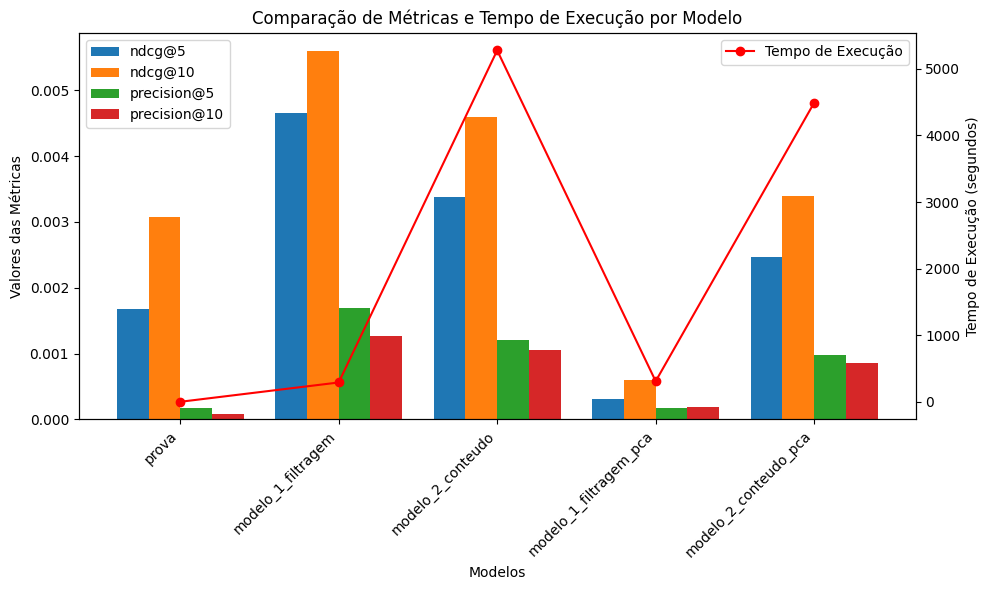

In [42]:
# dados
modelos = list(resultados.keys())
metricas = ["ndcg@5", "ndcg@10", "precision@5", "precision@10"]
valores_metricas = [[resultados[modelo][metrica] for metrica in metricas] for modelo in modelos]
tempos = [resultados[modelo]["tempo"] if resultados[modelo]["tempo"] is not None else 0 for modelo in modelos]

# para o tempo
x = np.arange(len(modelos))
width = 0.2

fig, ax1 = plt.subplots(figsize=(10, 6))

# Barras
for i, metrica in enumerate(metricas):
    valores = [resultados[modelo][metrica] for modelo in modelos]
    ax1.bar(x + i * width, valores, width, label=metrica)

# eixo esquerdo (Métricas)
ax1.set_xlabel("Modelos")
ax1.set_ylabel("Valores das Métricas")
ax1.set_title("Comparação de Métricas e Tempo de Execução por Modelo")
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(modelos, rotation=45, ha="right")
ax1.legend(loc="upper left")

#  eixo direito
ax2 = ax1.twinx()
ax2.plot(x + width * 1.5, tempos, color="red", marker="o", label="Tempo de Execução")
ax2.set_ylabel("Tempo de Execução (segundos)")
ax2.legend(loc="upper right")

# layout
plt.tight_layout()
plt.show()

>>

>> Com o grafico acima conseguimos ver o empenho dos modelos, com e sem PCA, em relacao aos dados fornecidos pela prova.

>> Um fato interessante é o impacto do PCA, tanto no desempenho quanto no tempo de execução o que já era esperado. Por reduzir a dimensionalidade das matrizes o tempo de execução para ambos os modelos com PCA foi reduzido, mas há um preço alto por isso que foi o impacto no desempenho reduzindo para ambos o que indica a perda de informações relevantes para a recomendação. Pode ter sido a escolha da dimensionalidade? Talvez, um teste a se fazer é dobrar ou até mesmo triplicar o valor original do PCa que foi de 50.

>> Outro fato a se notar a diferença no desempenho do modelo antes e depois do PCA. Para o modelo baseado em conteudo houve um perda, mas nem tanto, considerando que seu tempo foi reduzido em quase 1000 segundos. Porém para o modelo com filtragem colaborativa a coisa foi diferente. Enquanto o tempo de execução teve uma diferença muito leve, o desempenho mudou completamente, reduzindo drasticamente esses valores.

>> Acreditamos que o essa diferença tao grande se deve ao fato desse modelo colaborativo depender fortemente da matriz original para calcular a similaridades entre usuarios. Com a redução da dimensionalidade o modelo nao conseguiu capturar suficientemtenet a complexidade da interação entre usuários. Mais um vez, utilizamos um dimensao muito baixa quando comparada ao modelo original. Válido testar com muito mais.

### **e) Conclusões (1,5 pontos)**

Dica: Informe as conclusões obtidas. Compare os valores das métricas obtidas entre os modelos e justifique qual seria o melhor modelo a ser utilizado no momento. Foque em convencer o gestor de que os seus modelos de recomendações são bons e qual seria o melhor a ser utilizado apresentando o motivo/justificativa.

>> Nesse trabalho abordamos quatro sistemas de recomendação: Filtragem Colaborativa e Recomendação Baseada em Conteúdo, com e sem aplicação de PCA para redução de dimensionalidade. Cada modelo foi avaliado com base em métricas comum a todos: ndcg@5, ndcg@10, precision@5, precision@10 e o tempo de execução.

>> Os resultados obtidos mostram que cada abordagem tem seus pontos fortes e fracos e vmaos abordar cada um deles:
*   `Modelo 1 - Filtragem Colaborativa: ` Apresentou os melhores resultados (ndcg@ e precision@). Isso ocorre porque a filtragem colaborativa aproveita diretamente os padrões de interação, que são altamente específicos e eficazes, utilizando informações de outros usuários semelhantes para recomendar. O tempo de execução foi razoável (290 segundos), tornando-o um modelo eficiente e prático, quando comparado as demais é claro.
*   `Modelo 2 - Baseado em Conteúdo:` Embora tenha métricas inferiores ao Modelo 1, seu desempenho ainda supera o da prova, o qual nao sabemos qual baseline e parâmetros foram utilizados. No entanto, o tempo de execução foi alto de mais (mais de 5000 segundos), indicando que o modelo baseado em conteúdo, sem otimizações adicionais, pode ser inviável para aplicações em larga escala.
* `Filtragem Colaborativa com PCA:` A redução de dimensionalidade com PCA comprometeu significativamente o desempenho das recomendações desse modelo, pois diluiu quase que completamente as relações importantes entre usuários e itens. Lembrando que utilziamos um nuemro muito baixo (50) no PCA. Embora o tempo de execução tenha sido ligeiramente inferior ao modelo original, o impacto negativo no desempenho torna esta abordagem inviável.
* `Baseado em Conteúdo com PCA:` Apresentou um equilíbrio razoável entre desempenho e eficiência. Embora as métricas tenham sido inferiores ao modelo original, o tempo de execução foi reduzido em mais de 1000 segundos, mostrando que o PCA é uma estratégia viável para melhorar a escalabilidade em modelos baseados em conteúdo. E foi melhor que a baseline da prova. Uma otimização de parâmetros pode sim tornar esse o melhor modelo, basta testes.





---



>> Dito isso Chefe, o `Modelo 1 - Filtragem Colaborativa` é o mais indicado para o cenário da sua loja. Ele combina precisão, cobertura e eficiência computacional melhor que todos os outros que testamos, sendo capaz de gerar recomendações boas sem comprometer o tempo de execução. Indicando para seus clientes boas recomendações que podem induzí-lo a comprar mais e você ter um aumento na receita na loja. Se o fluxo da loja tiver um volume considerável de interações passadas entre usuários e itens, ou seja, clientes comprando e recebendo recomendações, esse modelo é o mais adequado com certeza. Podemos subir para aplicação?

>> Dado que fizemos o deploy do modelo na loja, a pesquisa não para. Precisamos realizar mais testes para saber se podemos melhorar esses resultados. Como teste Chefe, enquanto o modelo que você aprovou está rodando, sugerimos o seguinte:
*   Investir em otimizações do` Modelo 2 - Baseado em Conteúdo com PCA` para cenários onde as informações dos itens (e não das interações) são a principal fonte de dados.
*   Investir em otimizações do Modelo `1 - Filtragem Colaborativa com PCA` buscando melhorar sua performance uma vez que ele gasta menos poder de processamento, buscando um equilíbrio entre custo cumputacional e boas recomendações.
* Testar os modelos em um conjunto de `treino maior`, pois houve limitacoes nossas em questao de RAM do Colab.
* Avaliar a possibilidade de `combinar ambas as abordagens` em um modelo híbrido.


>>